# Calculate BIC

First try

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

from BIC_calculation import *

from classif_functions import *
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import sys
np.set_printoptions(threshold=sys.maxsize)

import configparser

### __User inputs__

Read configuration file

In [2]:
config_filename = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/ow_config.txt'

with open(config_filename) as f:
    file_content = '[configuration]\n' + f.read()

config_parser = configparser.RawConfigParser(comment_prefixes='%')
config_parser.read_string(file_content)
config = config_parser['configuration']

In [3]:
for key in config_parser['configuration']:  
    print(key)

historical_directory
historical_ctd_prefix
historical_bottle_prefix
historical_argo_prefix
float_source_directory
float_source_postfix
float_mapped_directory
float_mapped_prefix
float_mapped_postfix
float_calib_directory
float_calib_prefix
float_calseries_prefix
float_calib_postfix
float_plots_directory
config_directory
config_coastlines
config_wmo_boxes
config_saf
config_max_casts
map_use_pv
map_use_saf
mapscale_longitude_large
mapscale_longitude_small
mapscale_latitude_large
mapscale_latitude_small
mapscale_phi_large
mapscale_phi_small
mapscale_age_large
mapscale_age_small
map_p_exclude
map_p_delta


In [4]:
config['config_wmo_boxes']

'wmo_boxes.mat'

Reference data selection and paths

In [6]:
# depth for interpolation
max_depth = 1000
# chose season ('DJF', 'MAM', 'JJA', 'SON' or 'all') for training dataset
season = ['all']
# paths
WMOboxes_latlon='WMO_boxes_latlon.txt'
#wmo_boxes= config['config_directory'] + config['config_wmo_boxes']
wmo_boxes='wmo_boxes_argo.mat'
#ref_path = '/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology/'
ref_path = config['historical_directory']

Float you want to correct

In [7]:
# agulhas current
float_mat_path = config['float_source_directory'] + '/test3/3901915.mat'
float_WMO = 3901915
# southern ocean
#float_mat_path = config['float_source_directory'] + '/test2/3901928.mat'
#float_WMO = 3901928
# north atlantic 
#float_mat_path = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/data/float_source/test1/4900136.mat'
#float_WMO = 4900136

## 1. Load argo reference database

__Load argo reference database__

In [8]:
ds = get_refdata(float_mat_path = float_mat_path, 
                 WMOboxes_latlon = WMOboxes_latlon, 
                 wmo_boxes = wmo_boxes, 
                 ref_path = ref_path,
                 config = config,
                 map_pv_use = 0)

/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3100.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3200.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3300.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3400.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3500.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3101.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3201.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3301.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3401.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3501.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3302.mat
/home5/pharos/argo/DMARGO/OW/VER

In [9]:
print(ds)

<xarray.Dataset>
Dimensions:     (n_pres: 1032, n_profiles: 38018)
Coordinates:
    long        (n_profiles) float64 8.207 8.405 8.415 ... 351.5 351.7 351.7
    lat         (n_profiles) float64 -19.96 -19.76 -19.75 ... -43.63 -43.45
    dates       (n_profiles) datetime64[ns] 2007-01-19T10:09:04 ... 2018-05-2...
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 38013 38014 38015 38016 38017
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1026 1027 1028 1029 1030 1031
Data variables:
    pres        (n_pres, n_profiles) float64 10.0 10.0 10.0 10.0 ... nan nan nan
    temp        (n_pres, n_profiles) float64 21.88 22.46 22.31 ... nan nan nan
    sal         (n_pres, n_profiles) float64 35.62 35.67 35.64 ... nan nan nan
    source      (n_profiles) <U46 '1900165_145.BRECKOWENS' ... '5903260_301.S...
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


plot dataset

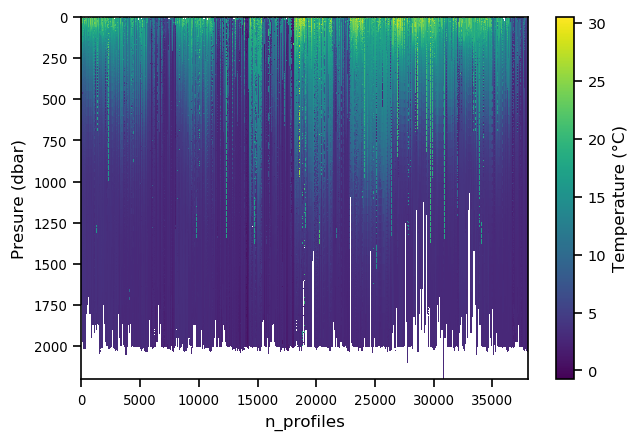

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(np.arange(len(ds['n_profiles'])), (len(ds['n_pres']),1)), ds['pres'], ds['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

__Interpolate to standard levels__

In [11]:
std_lev = np.arange(0,max_depth)
ds = interpolate_standard_levels(ds, std_lev)

/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:128: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [12]:
# some format
#pres should be negative for the PCM
ds['PRES_INTERPOLATED'] = -np.abs(ds['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds.lat.attrs['axis'] = 'Y'
ds.long.attrs['axis'] = 'X'
ds.dates.attrs['axis'] = 'T'

In [13]:
print(ds)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 36705)
Coordinates:
    long               (n_profiles) float64 8.207 8.405 8.415 ... 351.7 351.7
    lat                (n_profiles) float64 -19.96 -19.76 ... -43.63 -43.45
    dates              (n_profiles) datetime64[ns] 2007-01-19T10:09:04 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 38014 38015 38016 38017
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 10.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.62 ... 34.29
    source             (n_profiles) object '1900165_145.BRECKOWENS' ... '5903...
    temp               (n_profiles, PRES_INTERPOLATED) float64 21.88 ... 3.222
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


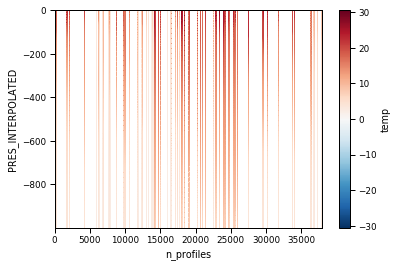

In [14]:
ds['temp'].plot(x='n_profiles');

Spatial distribution of dataset

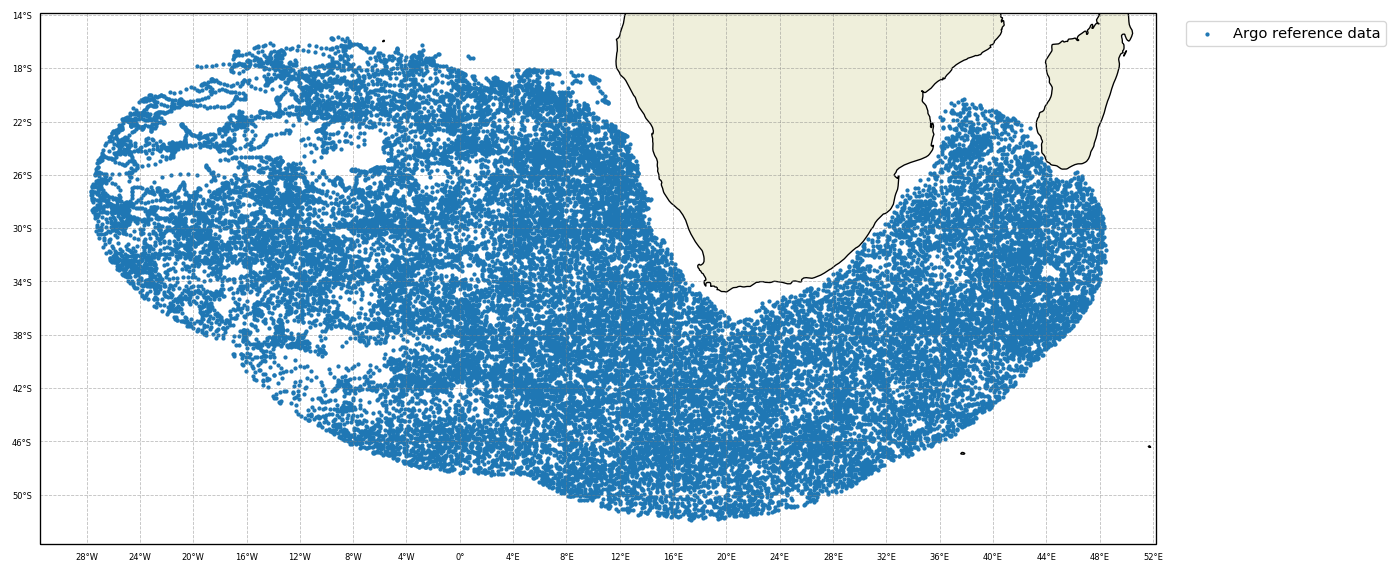

In [15]:
proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds['long'], ds['lat'], s=3, transform=proj, label='Argo reference data')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## 5. BIC plot

User input

In [16]:
corr_dist = 50 # correlation distance in km
time_steps = ['2018-01','2018-07']  # time steps to be used into account
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

In [17]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

In [18]:
def cal_dist_matrix(lats, lons):
    '''Calculate distance matrix

           Parameters
           ----------
               lats: latitude vector
               lons: longitude vector

           Returns
           ------
               Distance maytrix in int16

               '''    
    from sklearn.metrics.pairwise import haversine_distances
    from math import radians
    
    lats_in_radians = np.array([radians(_) for _ in lats])
    lons_in_radians = np.array([radians(_) for _ in lons])
    coords_in_radians = np.column_stack((lats_in_radians, lons_in_radians))
    dist_matrix = haversine_distances(coords_in_radians).astype(np.float32)
    dist_matrix = dist_matrix * 6371  # multiply by Earth radius to get kilometers
    dist_matrix = dist_matrix.astype(np.int16)
    
    return dist_matrix

In [19]:
def get_regulargrid_dataset(ds, corr_dist, season='all'):
    '''Re-sampling od the dataset selecting profiles separated the correlation distance

           Parameters
           ----------
               ds: reference profiles dataset
               corr_dist: correlation distance
               dist_matrix: distannces matrix
               season: choose season: 'DJF', 'MAM', 'JJA','SON' (default: 'all')

           Returns
           ------
               Re-sampled dataset

               '''
    
    ds['n_profiles'] = np.arange(len(ds['n_profiles']))
    # create mask
    mask_s = np.empty((1,len(ds['n_profiles'].values)))
    mask_s[:] = np.NaN
    ds["mask_s"]=(['n_profiles'],  np.squeeze(mask_s))
    
    plus_degrees = corr_dist/111 +1 # from km to degrees
    
    #loop
    n_iterations = range(len(ds['n_profiles'].values))
    for i in n_iterations:
        
        # choose random profile
        random_p = np.random.choice(ds['n_profiles'].where(np.isnan(ds['mask_s']), drop=True).values, 1, replace=False)
        random_p = int(random_p[0])
        lat_p = ds['lat'].sel(n_profiles = random_p).values
        long_p = ds['long'].sel(n_profiles = random_p).values
        
        # dataset arround random point
        ds_slice = ds.where(ds['lat'] > (lat_p - plus_degrees), drop=True)
        ds_slice = ds_slice.where(ds_slice['lat'] < (lat_p + plus_degrees), drop=True)
        ds_slice = ds_slice.where(ds_slice['long'] > (long_p - plus_degrees), drop=True)
        ds_slice = ds_slice.where(ds_slice['long'] < (long_p + plus_degrees), drop=True)
        random_p_i = np.argwhere(ds_slice['n_profiles'].values == random_p)
        
        # calculate distance matrix
        dist_matrix = cal_dist_matrix(ds_slice['lat'].values, ds_slice['long'].values)
        
        # points near than corr_dist = 1
        mask_dist = np.isnan(ds_slice['mask_s'].values)*1
        dist_vector = np.array(np.squeeze(dist_matrix[:,random_p_i])).astype('float')*np.array(mask_dist)
        dist_vector[dist_vector == 0] = np.NaN
        bool_near_points = (dist_vector < corr_dist)
        n_profiles_near_points = ds_slice['n_profiles'].values[bool_near_points]
        
        # change mask
        ds['mask_s'][random_p] = 1
        ds['mask_s'][n_profiles_near_points] = 0
        
        # stop condition
        #print(sum(np.isnan(ds['mask_s'].values)))
        if np.any(np.isnan(ds['mask_s'])) == False:
            print('no more points to delate')
            print(i)
            break
                            
    # choose season
    if 'all' not in season:
        season_idxs = ds.groupby('dates.season').groups

        season_select = []
        for key in season:
            season_select = np.concatenate(
                (season_select, np.squeeze(season_idxs.get(key))))

        if len(season) == 1:
            season_select = np.array(season_select)

        season_select = np.sort(season_select.astype(int))
        ds = ds.isel(n_profiles=season_select)
    
    ds_t = ds.where(ds['mask_s']== 1, drop=True)
    
    del dist_matrix

    return ds_t

In [20]:
def BIC_cal(X, k, pcm_features):
    ''' Function that calculates BIC for a number of classes k

            Parameters
            ----------
                X: dataset after preprocessing
                k: number of classes

            Returns
            ------
                BIC: BIC value
                k: number of classes

           '''

    # create model
    m = pcm(K=k + 1, features=pcm_features)
    # fit model
    m._classifier.fit(X)

    # calculate LOG LIKEHOOD
    llh = m._classifier.score(X)

    # calculate Nb of independant parameters to estimate
    # we suppose m._classifier.covariance_type == 'full'
    _, n_features = m._classifier.means_.shape
    cov_params = m._classifier.n_components * \
                 n_features * (n_features + 1) / 2.
    mean_params = n_features * m._classifier.n_components
    Nf = int(cov_params + mean_params + m._classifier.n_components - 1)

    # calculate bic
    N_samples = X.shape[0]
    BIC = (-2 * llh * N_samples + Nf * np.log(N_samples))
    # BIC = m._classifier.bic(X)

    return BIC, k

In [ ]:
%%time
ds_run = get_regulargrid_dataset(ds, corr_dist)

In [ ]:
proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_run['long'], ds_run['lat'], s=3, transform=proj, label='Argo reference data')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

BIC calculation

In [24]:
%%time

# create distance matrix
#dist_matrix = cal_dist_matrix(ds['lat'].values, ds['long'].values)

BIC = np.zeros((NK-1, Nrun))

for run in range(Nrun):
    print(run)
    # get sub-sampling dataset
    print('subsampling ...')
    ds_run = get_regulargrid_dataset(ds, corr_dist)
    
    # pre-processing
    # K=4 it is not important, it is only used for preprocess data
    print('preprocesing ...')
    m = pcm(K=4, features=pcm_features)
    X, sampling_dims = m.preprocessing(ds_run, features=features_in_ds, dim=z_dim, action='fit')
    
    print('bic calculation ...')
    BICi=[]
    for k in range(1,NK):
        print(k)
        print(BIC_cal(X, k, pcm_features)[0])
        BICi.append(BIC_cal(X, k, pcm_features)[0])
        
    BIC[:, run] = np.array([i for i in BICi])
    print(BIC)
    
BICmean = np.mean(BIC, axis=1)
BICstd = np.std(BIC, axis=1)

0
subsampling ...
no more points to delate
3669
preprocesing ...
bic calculation ...
1
-218609.21853107595
2
-240023.76157164254
3
-251504.49226912623
4
-252019.83082025548
5
-256197.45918826538
6
-258830.9776621738
7
-258188.9222963001
8
-257268.0928634564
9
-255312.7172939241
10
-253513.21672424104
11
-251566.38765773707
12
-250784.50347539745
13
-248137.8940797387
14
-244513.28559552235
15
-243151.57090852736
16
-241231.36964682234
17
-238066.31780838824
18
-234287.12483548786
19
-231065.24399793881
[[-223234.81480412       0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [-240023.76157164       0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [-251504.49226913       0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [-252019

BIC plot

BIC min: 6


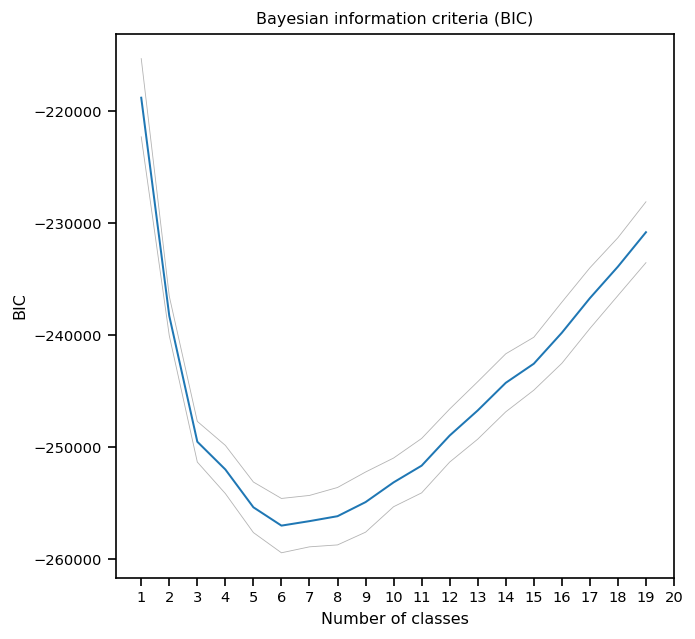

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k')
ax.plot(np.arange(NK-1) + 1, BICmean, label='BIC mean')
ax.plot(np.arange(NK-1) + 1, BICmean + BICstd,
             color=[0.7] * 3, linewidth=0.5, label='BIC std')
ax.plot(np.arange(NK-1) + 1, BICmean - BICstd, color=[0.7] * 3, linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of classes')
plt.xticks(np.arange(NK) + 1)
plt.title('Bayesian information criteria (BIC)')

print('BIC min: ' + str(np.argmin(BICmean) + 1))